In [3]:
import os
!gdown 1-1iPIpGC8ghlPUsotJmgKjUgs91ZqEyR

Downloading...
From (original): https://drive.google.com/uc?id=1-1iPIpGC8ghlPUsotJmgKjUgs91ZqEyR
From (redirected): https://drive.google.com/uc?id=1-1iPIpGC8ghlPUsotJmgKjUgs91ZqEyR&confirm=t&uuid=8e5f46d1-2b8b-4184-9ac0-cda35a8fe04b
To: /content/dataA_upsampled.pt
100% 384M/384M [00:02<00:00, 134MB/s]


In [4]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import numpy as np
import random
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('gpu')
else:
  device = torch.device('cpu')
  print('cpu')

dataA = torch.load('dataA_upsampled.pt',map_location=device)
print(len(dataA))


gpu
1500


In [ ]:
# Define the convolutional function as in LAB2A
def convolution_1D(signal,filter):
    print(f"filter shape for 1D convolution: {filter.size()}")
    print(f"signal shape for 1D convolution: {signal.size()}")
    taps = filter.shape[-1]
    z = torch.zeros(signal.shape)
    for k in range(taps):
        z = z + signal * filter[k]
        signal = torch.roll(signal, shifts=1, dims=-1)
        signal[:,:,0] = 0
    print(f"feature shape for 1D convolution: {z.size()}")
    return z

# Define the convolutional layer that inherits from nn.Module
# and implements (1) using convolution_1D
class Convolutional_Layer(nn.Module):
    def __init__(self,taps):
        super().__init__()
        self.filter = torch.nn.Parameter(torch.ones(taps)) # TODO: why do we use ones instead of randn

    def forward(self,x):
        return convolution_1D(x,self.filter)

# Define the CNN, which also inherits from nn.Module
# and has L layers, where each layer instantiates the convolutional_layer class
class CNN(nn.Module):
    def __init__(self, L,taps):
        '''
        inputs:
            L (int): number of layers
            taps (list[int]): list with number of taps for each layer
        '''
        super().__init__()
        self.L = L
        assert len(taps) == L, f"There are {L} layers, but taps is a vector of length {len(taps)}"
        self.conv_layers = []
        for i in range(L):
            self.conv_layers.append(Convolutional_Layer(taps[i]))


    def forward(self, x):
        for i in range(self.L):
            # compute the convolution
            x = self.conv_layers[i](x)
            if i != self.L-1:

                x = torch.tanh(x) # apply non-linearity after each convolution
        return x

In [ ]:
cnn = convolution_1D(torch.randn(10,1,1), torch.ones(2))
print(cnn)

filter shape for 1D convolution: torch.Size([2])
signal shape for 1D convolution: torch.Size([10, 1, 1])
feature shape for 1D convolution: torch.Size([10, 1, 1])
tensor([[[ 0.6614]],

        [[ 0.2669]],

        [[ 0.0617]],

        [[ 0.6213]],

        [[-0.4519]],

        [[-0.1661]],

        [[-1.5228]],

        [[ 0.3817]],

        [[-1.0276]],

        [[-0.5631]]])


In [ ]:
def MIMO_convolution_1D(signal,filter):
    print(f"signal of shape {signal.size()}")
    print(f"filter of shape {filter.size()}")
    taps = filter.shape[0]
    G = filter.shape[1]
    N = signal.shape[-1]
    batch = signal.shape[0]
    z = torch.zeros((batch, G, N)).to(device)
    for k in range(taps):
        z += torch.matmul(filter[k], signal)
        signal = torch.roll(signal, shifts=1, dims=-1)
        signal[:,:,0] = 0
    print(f"output of shape {z.size()}")
    return z

def MIMO_convolution(x, filter):
  y = torch.zeros(filter.shape[1], x.shape[1])
  for k in range(filter.shape[0]):
    y += filter[k] @ x
    x = torch.roll(x, shifts = 1, dims = 2)
    x[:, 0] = 0
  return y


class CNNLayer_MIMO(nn.Module):
  def __init__(self, K, F, G):
    super().__init__()
    self.filter = nn.Parameter(torch.empty(K, G, F))
    nn.init.xavier_normal_(self.filter)
  def forward(self, x):
    return MIMO_convolution_1D(x, self.filter)


In [ ]:
# Define the CNN

class MIMO_CNN(nn.Module):
    def __init__(self, L,taps,features):
        '''
        inputs:
            L (int): number of layers
            taps (list[int]): list with number of taps for each layer [K1, ..., KL]
            features: list with number of features of each layer [F0, ..., FL]
        '''
        super().__init__()
        self.L = L
        assert len(taps) == L, f"There are {L} layers, but taps is a vector of length {len(taps)}"
        assert len(features) == L+1, f"There are {L} layers, but features is a vector of length {len(features)} (There has to be L+1 features)"
        self.layers = nn.ModuleList()
        for i in range(L):
            self.layers.append(CNNLayer_MIMO(F=features[i],G=features[i+1],K=taps[i]))

    def forward(self, x):
        for i in range(self.L):
            x = self.layers[i](x)
            if i != self.L-1:
              x = torch.tanh(x)
        return x

Device: cuda:0
1500
torch.Size([1, 32000])


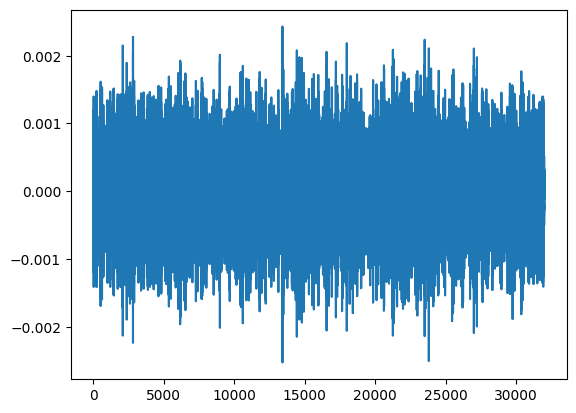

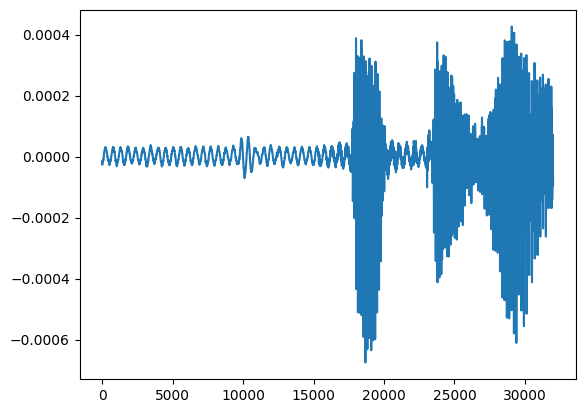

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio

dataset_name = 'dataA_upsampled.pt'
sample_rate = 32000

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
dataB = torch.load(dataset_name,map_location=device)
print(f'Device: {device}')

# Take one sample and separate x and y
data_0 = dataB[0]
x_0 = data_0[0].cpu()
y_0 = data_0[1].cpu()

print(len(dataB))
print(x_0.shape)

# Noisy signal plot and play
plt.plot(x_0[0])
plt.show()
display(Audio(x_0[0],rate=sample_rate))

# Original signal plot and play
plt.plot(y_0[0])
plt.show()
display(Audio(y_0,rate=sample_rate))

# Split into train and test

test_size = 100
train_size = len(dataB) - test_size

test_set_B, train_set_B =  torch.utils.data.random_split(dataB, [test_size, train_size])

In [ ]:

def evaluate(dataloader, estimator):
    loss = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            yHat = estimator.forward(x_batch)
            loss += torch.mean((yHat-y_batch)**2)
    numBatchs = len(dataloader)
    loss /= numBatchs
    return loss.item()

Streaming output truncated to the last 5000 lines.
shape of x: torch.Size([32, 5, 32000])
signal of shape torch.Size([32, 5, 32000])
filter of shape torch.Size([40, 1, 5])
output of shape torch.Size([32, 1, 32000])
torch.Size([32, 1, 32000])
signal of shape torch.Size([32, 1, 32000])
filter of shape torch.Size([40, 5, 1])
output of shape torch.Size([32, 5, 32000])
torch.Size([32, 5, 32000])
shape of x: torch.Size([32, 5, 32000])
signal of shape torch.Size([32, 5, 32000])
filter of shape torch.Size([40, 1, 5])
output of shape torch.Size([32, 1, 32000])
torch.Size([32, 1, 32000])
signal of shape torch.Size([32, 1, 32000])
filter of shape torch.Size([40, 5, 1])
output of shape torch.Size([32, 5, 32000])
torch.Size([32, 5, 32000])
shape of x: torch.Size([32, 5, 32000])
signal of shape torch.Size([32, 5, 32000])
filter of shape torch.Size([40, 1, 5])
output of shape torch.Size([32, 1, 32000])
torch.Size([32, 1, 32000])
signal of shape torch.Size([4, 1, 32000])
filter of shape torch.Size([40

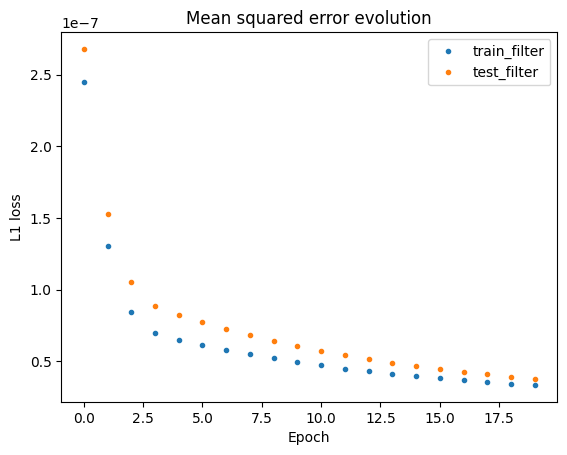

In [ ]:
# SAME TRAINING LOOP as in previous lab BUT WITH MIMO_CNN AS ESTIMATOR
L = 2
taps = [40, 40]
features = [1,5,1]
estimator = MIMO_CNN(L=L,taps=taps,features=features)
lr=0.5
batch_size = 32

optimizer = optim.SGD(estimator.parameters(), lr=lr)
loss_L1 = nn.L1Loss()
estimator.to(device)


# Instantiate Data Loaders
train_loader_CL = DataLoader(
    train_set_B,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_CL = DataLoader(
    test_set_B,
    batch_size=batch_size,
    shuffle=False,
)

loss_evolution = []
loss_evolution_test = []

# Training loop
n_epochs = 20

# Iterate n_epochs times over the whole dataset.
for ep in range(n_epochs):
    i=0
    #iterate over all batches in the dataset
    for x_batch, y_batch in train_loader_CL:
        i+=1

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Set gradients to zero
        estimator.zero_grad()

        # Compute predictions
        yHat = estimator.forward(x_batch)

        # Compute loss
        loss = loss_L1(yHat,y_batch)
        loss.backward()

        # Update parameters
        optimizer.step()
    epoch_loss_filter = evaluate(train_loader_CL, estimator)
    loss_evolution.append(epoch_loss_filter)

    lossTest_filter = evaluate(test_loader_CL, estimator)
    loss_evolution_test.append(lossTest_filter)
    print(f'epoch {ep+1} / {n_epochs} loss {lossTest_filter}',end='\r')

# Plot results
_ = plt.plot(loss_evolution, ".", label="train_filter")
_ = plt.title("Mean squared error evolution")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("L1 loss")
_ = plt.plot(loss_evolution_test, ".", label="test_filter")
_ = plt.legend()


In [ ]:
print(f"final train loss: {loss_evolution[-1]}")
print(f"final test loss {loss_evolution_test[-1]}")

final train loss: 3.35133556461642e-08
final test loss 3.785348212659301e-08


In [ ]:
# Listen to the samples

# (change to try other audios)
nmbr_example = 0

x_batch, y_batch = next(iter(test_loader_CL))
sample_x, sample_y = x_batch[nmbr_example], y_batch[nmbr_example]
sample_x = sample_x.reshape(sample_x.shape[0], 1, sample_x.shape[1])
predicted_y = estimator(sample_x).detach()[0]

sample_x = sample_x.cpu()
sample_y = sample_y.cpu()
predicted_y = predicted_y.cpu()

print(f'Original Audio')
display(Audio(sample_y, rate=sample_rate))

print(f'Noisy Audio')
display(Audio(sample_x.reshape(sample_x.shape[0],sample_x.shape[2]), rate=sample_rate))

print(f'Audio recovered with filter')
display(Audio(predicted_y, rate=sample_rate))

signal of shape torch.Size([1, 1, 32000])
filter of shape torch.Size([40, 5, 1])
output of shape torch.Size([1, 5, 32000])
torch.Size([1, 5, 32000])
shape of x: torch.Size([1, 5, 32000])
signal of shape torch.Size([1, 5, 32000])
filter of shape torch.Size([40, 1, 5])
output of shape torch.Size([1, 1, 32000])
torch.Size([1, 1, 32000])
Original Audio


Noisy Audio


Audio recovered with filter


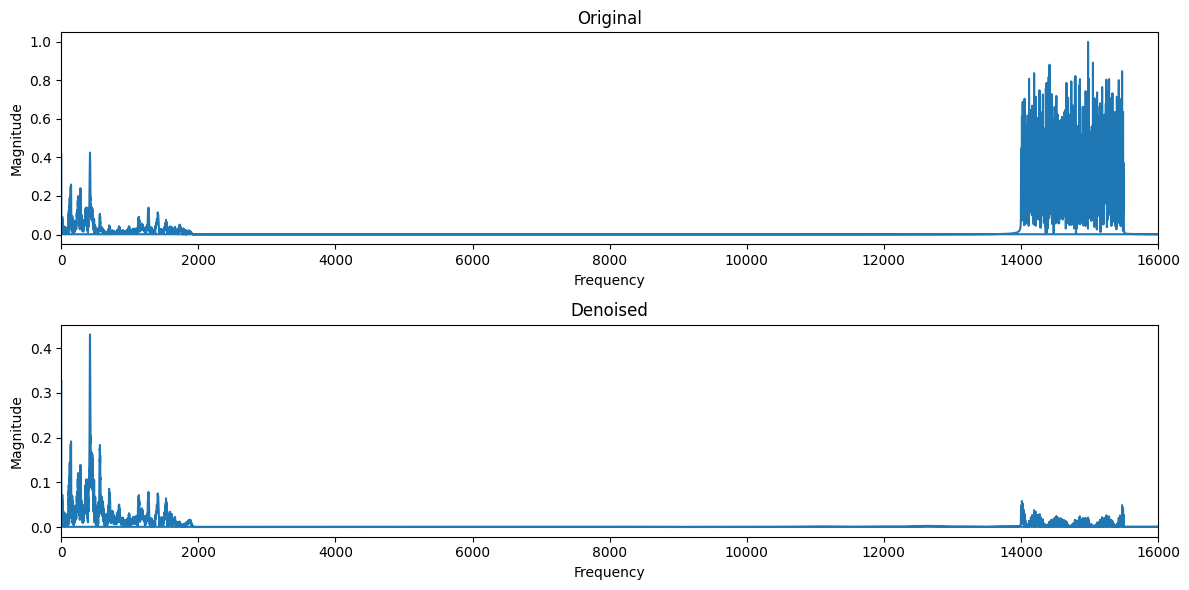

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

signal1 = sample_x.cpu()[0]
signal2 = predicted_y.cpu()

sample_rate=32000

# Compute the Fourier Transform
fft_signal1 = np.fft.fft(signal1)
fft_signal2 = np.fft.fft(signal2)

# Compute the frequency axis
N = signal1.shape[1]
freq = np.fft.fftfreq(N, d=1/sample_rate)

# Plot the magnitude spectrum of the Fourier Transform for both signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(freq, np.abs(fft_signal1.T))
plt.title('Original')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, sample_rate / 2)  # Limiting x-axis to half the sampling rate (Nyquist frequency)

plt.subplot(2, 1, 2)
plt.plot(freq, np.abs(fft_signal2.T))
plt.title('Denoised')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, sample_rate / 2)  # Limiting x-axis to half the sampling rate (Nyquist frequency)

plt.tight_layout()
plt.show()

display(Audio(signal1,rate=sample_rate))
display(Audio(signal2,rate=sample_rate))